In [56]:
import numpy as np
import xarray as xr
import pandas as pd
import pyproj 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
from sklearn.metrics import confusion_matrix
import geopandas as gpd 
from scipy.spatial import cKDTree

plot_proj = cartopy.crs.Stereographic(central_longitude=-45,central_latitude=90,true_scale_latitude=70)
blue_perennial =  (74/255,130/255,191/255)
old_names = dict({'CP1': 'CrawfordPoint1', 'DY2': 'DYE-2', 'HUM': 'Humboldt', 'NAE': 'NASA-E', 'NAU': 'NASA-U', 
                  'NEM': 'NEEM', 'NSE': 'NASA-SE','SDM': 'SouthDome', 'SDL': 'Saddle', 'TUN': 'Tunu-N', 
                  'SWC': 'SwissCamp','Summit': 'Summit', 'PetermannELA': 'PetermannELA', 'GITS': 'GITS'})

# Define colors: 
color_racmo =  (208/255,28/255,31/255)
color_mar = (225/255,126/255,4/255)
color_hirham5 = (47/255,158/255,49/255) 
color_hirhami = (74/255,130/255,191/255)

In [94]:
#############################################
###########  CHOOSE RCM TO USE  #############
#############################################
home_dir = '/Volumes/disk3s1/enveo/'
home_dir2 = '/Users/annpu/Desktop/'
rcm_name = 'HIRHAM_ERA5'
#############################################
#############################################   

# Load in AWS stations and mask applied to select AWS stations: 
aws_loc = pd.read_csv(home_dir + '/AWS/combined/AWS_latest_locations.csv')
ASCAT_mask =gpd.read_file('/Volumes/disk3s1/enveo/QGIS/ASCAT_mask.geojson') #gpd.read_file(home_dir + '/snowline/2020_snowline_epsg3413.geojson')
#ASCAT_mask = gpd.read_file(home_dir + '/snowline/2020_snowline_epsg3413.geojson')
# set station ID as index and remove stations where we don't have datafiles from:
aws_loc = aws_loc.set_index('stid')
aws_loc = aws_loc.drop(['QAS_Lv3','ZAK_L','WEG_L', 'KPC_Uv3', 'KPC_Lv3']) # remove nan entry and st where I dont have data. 

# Convert to geopandas dataframe and reproject to EPSG:3413:
gdf = gpd.GeoDataFrame(aws_loc, geometry=gpd.points_from_xy(aws_loc.lon, aws_loc.lat), crs="EPSG:4326").to_crs('EPSG:3413')

# Clip to ASCAT mask
clipped_aws_loc = gpd.clip(gdf, ASCAT_mask)

# save clipped AWS locations to file:
clipped_aws_loc.to_file(home_dir + '/AWS/combined/clipped_aws_loc.geojson', driver='GeoJSON')
print(len(clipped_aws_loc))
# Import RCM data in ASW locations: 
AWS_RCM = get_melt_in_points(home_dir2, [2007, 2020], clipped_aws_loc, rcm_name) 

38
Loaded data for: 2007
Nearest coordinates found

2008
data loaded
2009
data loaded
2010
data loaded
2011
data loaded
2012
data loaded
2013
data loaded
2014
data loaded
2015
data loaded
2016
data loaded
2017
data loaded
2018
data loaded
2019
data loaded
2020
data loaded


-1.0 11.8 4.925837320574163
-0.8 11.8 4.783094098883573
11.8
-0.6000000000000001 11.8 4.6746411483253585
-0.40000000000000013 12.200000000000001 4.597288676236045
-0.20000000000000018 12.8 4.4896331738437
-2.220446049250313e-16 12.8 4.410685805422648
0.19999999999999973 13.200000000000001 4.385167464114832
0.3999999999999997 13.8 4.321371610845295
0.5999999999999996 14.3 4.2894736842105265
0.7999999999999996 14.5 4.261562998405104
0.9999999999999996 15.600000000000001 4.302232854864434


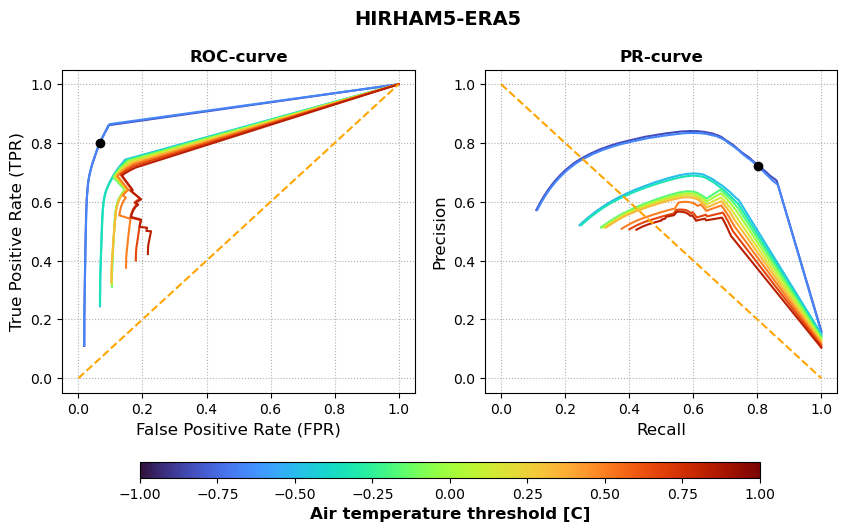

In [97]:
#####################################################################
############# CHOOSE PARAMETERS TO ON HOW TO THRESHOLD  #############
#####################################################################
thresholds = np.arange(0,51,0.1)
temp_th_lims = [-1,1]
temp_th_stp = 0.2
#####################################################################
#####################################################################

# Initialize DataFrame to store agreement results:
#agreement_df = pd.DataFrame(columns=AWS_RCM.columns, index=thresholds)
# Initialize array with temp thresholds:
temp_thresholds = np.arange(temp_th_lims[0],temp_th_lims[1]+temp_th_stp, temp_th_stp)

# Set up figure: 
fig,ax = plt.subplots(1,2,figsize = (10,6))#, facecolor='#f1edec')
#cmap = plt.get_cmap('viridis_r',len(temp_thresholds))  # define the colormap
#cmap = plt.get_cmap(sns.color_palette("rocket_r",as_cmap=True), len(temp_thresholds))

cmap = sns.color_palette('turbo', len(temp_thresholds))
cmap2 = sns.color_palette('turbo', as_cmap = True)
# Use the colors list to create a colormap
c = 0  # color index

# Initialize confusion matrix:
cm = np.zeros((len(clipped_aws_loc),len(thresholds), 2,2))

for threshold_AWS in temp_thresholds:
    agreement_df = pd.DataFrame(columns=AWS_RCM.columns, index=thresholds)

    for i in range(len(AWS_RCM.columns)):
        # Load in data from AWS station:
        id = AWS_RCM.columns[i] # AWS station ID
        AWS_airtemp = load_AWS_data(id)

        # Data from that given station: 
        AWS_RCM_st = AWS_RCM[id].to_frame() # RCM melt data at that station
        
        # Merge DataFrames to only get when dates is overlapping: 
        merged_df = AWS_airtemp.merge(AWS_RCM_st, left_index=True, right_index=True, how='inner')
        merged_df = merged_df.dropna() # Remove nan values (if there are any)
        
        
        # Only continue if there data in the matching period: 
        if len(merged_df) > 0: 
            # Removed dates with nan measurements: 
            agreement_count = np.zeros(len(thresholds))
                
            for j in range(len(thresholds)):
                # Compute agreement between RCM and AWS: 
                threshold_RCM = thresholds[j] # Threshold for RCM
                
                merged_df['th_rcm'] = merged_df[id] >= threshold_RCM # Melt in RCM. 
                merged_df['th_aws'] = merged_df['t_u'] >= threshold_AWS # Melt in AWS.
                agreement_count[j] = len(merged_df) - ((merged_df['th_rcm'] & merged_df['th_aws']).sum() + (~(merged_df['th_rcm']) & ~(merged_df['th_aws'])).sum())
                
                cm[i,j,:,:] = confusion_matrix(merged_df['th_aws'], merged_df['th_rcm'])
                    #TPR = cm[1,1] / (cm[1,0] + cm[1,1])
                    #FPR = 1 - cm[0,0] / (cm[0,0] + cm[0,1])
                            
            agreement_df[id] = agreement_count
            

    # Drop the stations where there where no data in the period: 
    agreement_df = agreement_df.dropna(axis='columns', how='all')
    agreement_df['all_st'] = agreement_df.mean(axis=1)/len(clipped_aws_loc)
    #agreement_df.all_st.plot(ax = ax[0], c=cmap[c])
    
    best_th = agreement_df.all_st.idxmin()
    id_bt = int(best_th*10)
    print(threshold_AWS, best_th, agreement_df.loc[best_th].all_st)
    #ax.scatter(best_th/2, agreement_df.iloc[best_th].all_st, color = cmap(c), zorder = 100, label = 'Bedst threshold')

    # Compute true positive and false postive rate: 
    cm_sum = np.sum(cm, axis = 0)
    TPR = cm_sum[:,1,1] / (cm_sum[:,1,0] + cm_sum[:,1,1])
    FPR = 1 - cm_sum[:,0,0] / (cm_sum[:,0,0] + cm_sum[:,0,1])
    precision = cm_sum[:,1,1] / (cm_sum[:,1,1]  + cm_sum[:,0,1])
    recall = cm_sum[:,1,1] / (cm_sum[:,1,1]  + cm_sum[:,1,0])
    f1_score = 2 * (precision * recall) / (precision + recall) # F1 score
    ax[1].plot(recall,precision, '-', color = cmap[c])
    ax[0].plot(FPR,TPR, '-', color = cmap[c])
    #ax[1].scatter(FPR[id_bt],TPR[id_bt], color = 'black')
    #ax[1].scatter(recall[id_bt],precision[id_bt], color = cmap[c])
    #ax[1].plot(thresholds, f1_score, color = cmap[c])
    #ax[1].set_xscale('log')

    c+= 1
    if c == 2: 
        print(best_th)
        id_bt = 60
        ax[0].scatter(FPR[id_bt], TPR[id_bt], color='black', zorder=10)
        ax[1].scatter(recall[id_bt],precision[id_bt], color = 'black', zorder=10)
        



line = np.linspace(0,1) # Line for plotting
ax[0].plot(line,line, '--', color = 'orange', label = 'No skill')
ax[1].plot(line,np.flip(line), '--', color = 'orange', label = 'No skill')

#ax[1].scatter(FPR[id_bt],TPR[id_bt], color = 'black', label = 'Minimum misclassified days')
ax[1].set_ylabel('Precision', fontsize = 12)
ax[1].set_xlabel('Recall', fontsize = 12)
ax[0].set_ylabel('True Positive Rate (TPR)', fontsize = 12)
ax[0].set_xlabel('False Positive Rate (FPR)', fontsize = 12)
#ax[0].set_ylim(0,10)
#ax[0].set_xlim(0, 20)
ax[0].grid(linestyle=':') 
ax[1].grid(linestyle=':') 
norm = mpl.colors.Normalize(vmin=temp_th_lims[0],vmax=temp_th_lims[1])
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
#plt.colorbar(sm, ax = ax[0], label = 'Air temperature threshold [C]')
#plt.colorbar(sm, ax = ax[1], label = 'Air temperature threshold [C]')
# S
#ax[1].legend()
ax[0].set_title(f'ROC-curve', fontweight = 'bold', fontsize = 12)
ax[1].set_title(f'PR-curve', fontweight = 'bold', fontsize = 12)
fig.suptitle('HIRHAM5-ERA5', fontweight = 'bold', fontsize = 14)

cbar = fig.colorbar(sm, ax=ax[:], label = 'Air temperature threshold [C]', location='bottom', shrink=0.8, aspect = 40, pad= 0.15)
cbar.set_label('Air temperature threshold [C]', fontsize=12, fontweight = 'bold')
#fig.tight_layout()
#plt.savefig(f'Thresholding_with_aws_{rcm_name}.png', bbox_inches = 'tight')

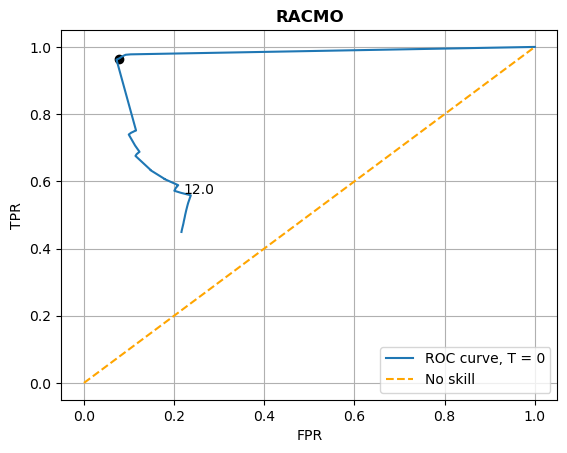

In [69]:
cm_sum = np.sum(cm, axis = 0)

TPR = cm_sum[:,1,1] / (cm_sum[:,1,0] + cm_sum[:,1,1])
FPR = 1 - cm_sum[:,0,0] / (cm_sum[:,0,0] + cm_sum[:,0,1])

#best= int(best_th*100)

fig,ax = plt.subplots(1)
ax.plot(FPR,TPR, '-', label = 'ROC curve, T = 0')
#ax.plot(FPR_1,TPR_1, '-', label = 'ROC curve, T = 1', color = 'green')
ax.plot(line,line, '--', label = 'No skill', color = 'orange')
ax.scatter(FPR[14],TPR[14], color = 'black')
#ax.scatter(FPR_1[28],TPR_1[28], color = 'black')
ax.text(FPR[141]+0.02,TPR[141]-0.01, f'{(best_th)}')
#ax.text(FPR_1[28]+0.02,TPR_1[28]-0.01, f'{(28)/2}')
ax.grid()
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'{rcm_name}', fontweight = 'bold')
ax.legend()
plt.savefig(f'ROC_curve_{rcm_name}.png', bbox_inches = 'tight')

Text(0.5, 1.0, 'HOW TO MAKE A NO SKILL LINE THAT MAKES SENSE!!!')

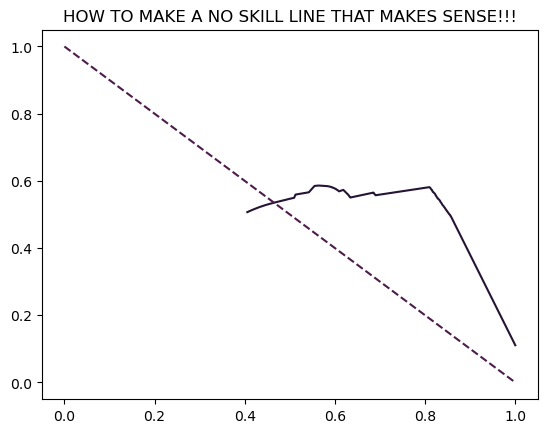

In [385]:
precision = cm_sum[:,1,1] / (cm_sum[:,1,1]  + cm_sum[:,0,1])
recall = cm_sum[:,1,1] / (cm_sum[:,1,1]  + cm_sum[:,1,0])
line = np.linspace(0,1)
plt.plot(recall, precision, '-')
#plt.scatter(recall[best_th],precision[best_th])
plt.plot(line,-line+1, '--')
plt.title('HOW TO MAKE A NO SKILL LINE THAT MAKES SENSE!!!')

NameError: name 'merged_df' is not defined

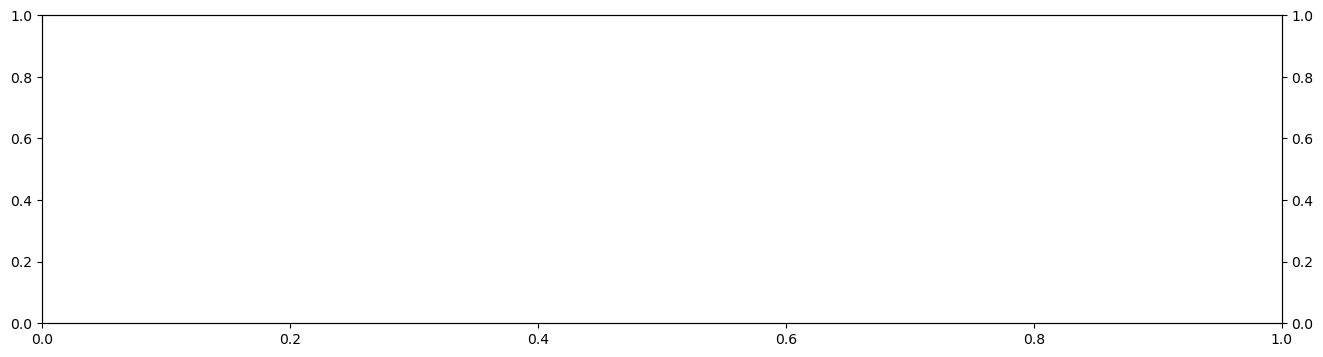

In [3]:
fig,ax1 = plt.subplots(1,1,figsize = (16,4))
ax2 = ax1.twinx()
ax1.plot(merged_df.loc['2016-01-01':'2019-12-31'].index,merged_df.loc['2016-01-01':'2019-12-31'][id],color = 'darkgrey')#, merged_df['t_u'], s = 1)
ax2.plot(merged_df.loc['2016-01-01':'2019-12-31'].index,merged_df.loc['2016-01-01':'2019-12-31']['t_u'], color = blue_perennial)#, merged_df['t_u'], s = 1)
ax2.set_ylim(-35,35)
ax1.set_ylim(-55,55)
ax1.grid(linestyle = ':')
ax1.set_xlim(np.datetime64('2016-01-01'), np.datetime64('2019-12-31'))
ax1.set_xlabel('Time', fontweight = 'bold')
ax1.set_ylabel('Surface melt in RCM [mmWE/day]', color = 'darkgray', fontweight = 'bold')
ax2.set_ylabel('Air Temperature [C]',  color = blue_perennial, fontweight = 'bold')
ax1.set_title(id)

In [ ]:
id = 'KAN_U'# AWS station ID
AWS_data = pd.read_csv(home_dir + f'/AWS/combined/day/{id}_day.csv') # Load in AWS data
AWS_data['time'] = pd.to_datetime(AWS_data['time']) # Convert to datetime
AWS_data = AWS_data.set_index('time') # Set time as index

        # Data from that given station: 
AWS_airtemp = AWS_data.t_u.to_frame() # Air temperature
AWS_RCM_st = AWS_RCM[id].to_frame() # RCM melt data at that station

merged_df = AWS_airtemp.merge(AWS_RCM_st, left_index=True, right_index=True, how='inner')
merged_df
#merged_df

,t_u,KAN_U
2009-04-04,-25.2648,-0.0
2009-04-05,-25.2971,-0.0
2009-04-06,-23.4368,-0.0
2009-04-07,-28.1828,-0.0
2009-04-08,-32.1525,-0.0
...,...,...
2020-12-27,-20.5656,-0.0
2020-12-28,-10.7387,-0.0
2020-12-29,-21.4599,-0.0
2020-12-30,-18.3424,-0.0


In [10]:
def load_dmidata(home_dir, year, rcm_name): 
    varlist = ['ahfl','ahfs','dlwrad','dswrad','evspsbl','rainfall','snfall','grndhflx','tsl2','gld','rogl',
           'tradsm','sradsm','albedom','supimp','tsl','rfrz']
    if rcm_name == 'HIRHAM_ERA5': 
            # Open and concatenate netCDF files into one dataset
            #RCM = xr.open_mfdataset(home_dir+f'/HIRHAM_2/Daily2D_{year}*.nc',
            #                    parallel=True, drop_variables = varlist,
            #                    concat_dim='time', combine='nested')
            RCM =  xr.open_mfdataset(home_dir + f'/HIRHAM5-ERA5_v2/Daily2D_{year}*.nc', 
                                parallel=True, drop_variables = varlist,
                                concat_dim='time', combine='nested')
    
    elif rcm_name == 'HIRHAM_ERAI':
        if year >= 2015: 
            RCM =  xr.open_mfdataset(home_dir + f'/HIRHAM/{year}/HIRHAM_{year}.nc', drop_variables = varlist)
        
        else:
            RCM = xr.open_mfdataset(home_dir+f'/HIRHAM/{year}/Daily2D_{year}*.nc',
                                parallel=True, drop_variables = varlist,
                                concat_dim='time', combine='nested') 
    
    return RCM
        
def sample_xarray_points(RCM, aws_df): 
    RCM_xy = RCM.sel(x = np.array(aws_df.geometry.x), y = np.array(aws_df.geometry.y), method = 'nearest')

    # Nu skal det så ind i en dataframe 
    data4df = np.zeros((np.size(RCM_xy.time), len(aws_df)))
    for i in range(len(aws_df)):
        # Set up data for dataframe:
        data4df[:, i] = np.array(RCM_xy.isel(x=i, y=i).ME).squeeze()

    #Put into dataframe:
    sampled_df = pd.DataFrame(data = data4df, 
                index = RCM_xy.time.dt.floor('d'),
                columns = list( aws_df.index))

    return sampled_df

# Function that loads in RCM from one netcdf-file in a given year and season. The functions then samples the data in the AWS locations and only returns the melt data at these locations.
def get_melt_in_points(home_dir, date_range, aws_df, rcm_name): 
    # Create a dataframe: 
    AWS_RCM = pd.DataFrame(columns = list(aws_df.index))

    # Since MAR and RACMO data structure are in the data structure the method is very similar:
    if rcm_name == 'MAR' or rcm_name == 'RACMO' or rcm_name == 'RACMO_s': 

        for year in range(date_range[0], date_range[1]+1):
            # Load RCM:
            
            if rcm_name == 'MAR':
                RCM = xr.open_dataset(home_dir + f'/marv3.12/MARv3.12.1-10km-daily-ERA5-{year}.nc')
                # For MAR we need to correct the xy to m:
                RCM.coords['x'] = RCM.coords['x']*1000
                RCM.coords['y'] = RCM.coords['y']*1000
                # Rename TIME to time:
                RCM = RCM.rename_vars({'TIME': 'time'})
                sampled_df = sample_xarray_points(RCM, aws_df)

            elif rcm_name == 'RACMO':
                seasons = ['AMJ', 'JAS', 'OND']
                RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_JFM.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
                # Rename snowmeltcorr to ME: 
                RCM = RCM.rename_vars({'snowmeltcorr': 'ME'})
                sampled_df = sample_xarray_points(RCM, aws_df)
                for s in seasons: # load in the rest of the seasons:
                    RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_{s}.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
                    # Rename snowmeltcorr to ME: 
                    RCM = RCM.rename_vars({'snowmeltcorr': 'ME'})
                    sampled_df_s = sample_xarray_points(RCM, aws_df)
                    sampled_df = pd.concat([sampled_df, sampled_df_s])

            elif rcm_name == 'RACMO_s': # only the JAS t2m data
                
                RCM = xr.open_dataset(home_dir + f'/RACMO2.3/t2m/t2m.{year}_JAS.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
                # remane t2m to TT: 
                RCM = RCM.rename_vars({'t2m': 'TT'})
                # Convert from km to m: 
                #RCM.coords['x'] = RCM.coords['x']*1000
                #RCM.coords['y'] = RCM.coords['y']*1000  
                # Sample in points:
                sampled_df = sample_xarray_points(RCM, aws_df)
                

            # concat onto dataframe:
            AWS_RCM = pd.concat([AWS_RCM, sampled_df])
            print(f'Dataframe updated for {year}\n')

    elif rcm_name == 'HIRHAM_ERA5' or rcm_name == 'HIRHAM_ERAI': 
       
        # Load HIRHAM for the first year:
        RCM = load_dmidata(home_dir, date_range[0], rcm_name)
        
        print('Loaded data for:', date_range[0])
        # Convert to the correct time format: (datetime64)
        time_index = np.arange(np.datetime64(f'{date_range[0]}-01-01'), 
                               np.datetime64(f'{date_range[0]+1}-01-01'), 
                               np.timedelta64(1, 'D'))

        # Flatten and stack latitude and longitude values to create a 2D grid
        lon = np.array(RCM.lon.data).flatten()
        lat = np.array(RCM.lat.data).flatten()
        lat_lon_grid = np.column_stack((lat, lon))

        # Build a KD-tree for efficient nearest neighbor searches
        tree = cKDTree(lat_lon_grid)
        
        # Extract AWS coordinates and find their nearest neighbors in the grid
        aws_coords = np.column_stack([aws_df.lat, aws_df.lon])
        dist , closest_indices = tree.query(aws_coords, k=1)

        print('Nearest coordinates found\n')
        # Reshape melt data for compatibility with the lat-lon grid
        melt_data = np.array(RCM.snmel.data).reshape(RCM.snmel.data.shape[0], -1)
        
        # Extract melt data for the nearest grid points
        melt_data_aws = melt_data[:, closest_indices]

        # Create a DataFrame with the melt data
        sampled_df = pd.DataFrame(data=melt_data_aws, 
                                  index=time_index,
                                  columns=list(aws_df.index))
        
        AWS_RCM = pd.concat([AWS_RCM, sampled_df])

        # Now sample the data in the remaining years: 
        for year in range(date_range[0]+1, date_range[1]+1):
            print(year)
            # Open files and combine into an annual dataset:
            RCM = load_dmidata(home_dir, year, rcm_name)
            print('data loaded')
            # Reshape melt data for compatibility with the lat-lon grid
            melt_data = np.array(RCM.snmel.data).reshape(RCM.snmel.data.shape[0], -1)
            
            # Extract melt data for the nearest grid points
            melt_data_aws = melt_data[:, closest_indices]

            time_index = np.arange(np.datetime64(f'{year}-01-01'), 
                                           np.datetime64(f'{year+1}-01-01'), 
                                           np.timedelta64(1, 'D'))
            
            # Create a DataFrame with the melt data
            sampled_df = pd.DataFrame(data=melt_data_aws, 
                                  index=time_index,
                                  columns=list(aws_df.index))
            AWS_RCM = pd.concat([AWS_RCM, sampled_df])

    return AWS_RCM


def load_AWS_data(id): 
    # If the AWS station is part of the old gc-net when we want to open the historical data:
    if id in ['CP1', 'DY2', 'HUM', 'NAE', 'NAU', 'NEM', 'NSA', 'NSE','SDM', 'SDL', 'TUN', 'SWC', 'Summit', 'PetermannELA', 'GITS']:
        id = old_names[id]
        # Load in AWS data:
        AWS_data = pd.read_csv(home_dir + f'/AWS/combined/historical/{id}_daily.csv', header = 14,low_memory=False)
        AWS_data= AWS_data.iloc[10:] # Remove first 10 rows where there no data. 
        AWS_data = AWS_data.astype({'TA1': 'float', 'TA2': 'float', 'TA3': 'float', 'TA4': 'float'}) # Convert to float
        
        # Compute mean of TA1, TA2, TA3, TA4 and store in a new column named t_u
        AWS_data['t_u'] = AWS_data[['TA1', 'TA2', 'TA3', 'TA4']].mean(axis=1)

        AWS_data = AWS_data.rename(columns = {AWS_data.columns[0]: 'time'}) # rename the first column to time
        #AWS_data.time = AWS_data.time.tz_localize(None) # Remove timezone info


    else: 
        # Load in AWS that part of PROMICE ogrinally:
        AWS_data = pd.read_csv(home_dir + f'/AWS/combined/day/{id}_day.csv') # Load in AWS data
    
    # Convert to datetime and set time as index:
    AWS_data['time'] = pd.to_datetime(AWS_data['time']) # Convert to datetime
    AWS_data = AWS_data.set_index('time') # Set time as index
    AWS_data.index = AWS_data.index.tz_localize(None) # remove tz 
    # select only t_u: 
    return AWS_data[['t_u']]



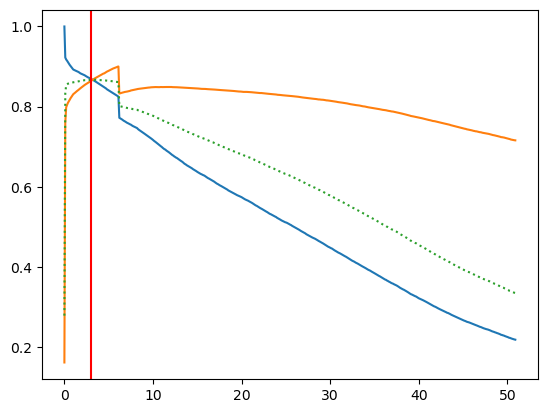

In [74]:
f1_score = 2 * (precision * recall) / (precision + recall)
plt.plot(thresholds, recall)
plt.plot(thresholds,precision)
plt.plot(thresholds,f1_score, ':')
plt.axvline(x=3, color='r')
#plt.xscale('log')

In [475]:
max_index = np.argmax(f1_score)
print(min_index, thresholds[max_index])


62 3.3000000000000003


<Axes: >

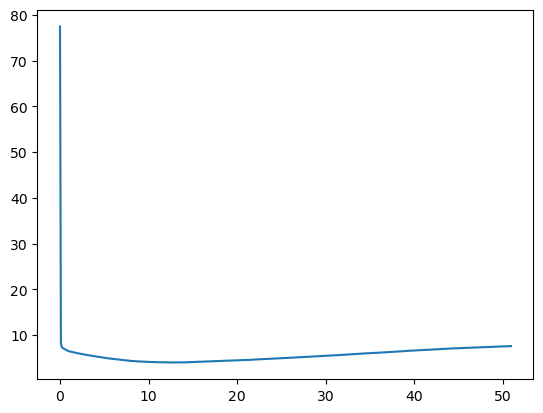

In [65]:
agreement_df.all_st.plot()


In [98]:
thresholds[60]

6.0

In [7]:
data4df = np.zeros((np.size(RCM_xy.time), len(clipped_aws_loc)))

for i in range(len(clipped_aws_loc)):
                # Set up data for dataframe:
    data4df[:, i] = np.array(RCM_xy.isel(x=i, y=i).snowmeltcorr).squeeze()
    

In [516]:
def load_racmo(year): 
    RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_JFM.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')

    seasons = ['AMJ', 'JAS', 'OND']
    for s in seasons: 
        RCM_s = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_{s}.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
        RCM = xr.concat([RCM, RCM_s], dim='time')
    return RCM

In [3]:
year = 2020
RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_JFM.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
RCM_s = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
RCM_s

<xarray.Dataset>
Dimensions:       (time: 91, x: 1496, y: 2700)
Coordinates:
  * time          (time) datetime64[ns] 2020-04-01 2020-04-02 ... 2020-06-30
  * x             (x) float32 -6.39e+05 -6.38e+05 ... 8.55e+05 8.56e+05
  * y             (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Data variables:
    LON           (y, x) float32 ...
    LAT           (y, x) float32 ...
    snowmeltcorr  (time, y, x) float32 ...
Attributes:
    title:        Daily snowmelt field (RACMO2.3p2)
    institution:  IMAU (Brice Noel)
    grid:         Map Projection:Polar Stereographic Ellipsoid - Map Referenc...
    history:      libUN (2013.05.22) - Mon Mar  8 03:48:57 2021
    netcdf:       4.7.4 of Apr 18 2020 10:56:44 $

In [9]:
def sample_xarray_points(RCM, aws_df): 
    RCM_xy = RCM.sel(x = np.array(aws_df.geometry.x), y = np.array(aws_df.geometry.y), method = 'nearest')
    print('Nearest coordinates found\n')

            # Nu skal det så ind i en dataframe 
    data4df = np.zeros((np.size(RCM_xy.time), len(aws_df)))
    for i in range(len(aws_df)):
        # Set up data for dataframe:
        data4df[:, i] = np.array(RCM_xy.isel(x=i, y=i).ME).squeeze()

    print('data for dataframe created\n')
            #Put into dataframe:
    sampled_df = pd.DataFrame(data = data4df, 
                index = RCM_xy.time.dt.floor('d'),
                columns = list( aws_df.index))

    return sampled_df

sample_xarray_points(RCM, clipped_aws_loc)

Nearest coordinates found

data for dataframe created

annual dataframe created



,QAS_L,QAS_M,QAS_U,QAS_Uv3,QAS_A,SDM,NUK_U,SDL,DY2,NSE,...,UPE_L,GITS,CEN1,CEN2,HUM,PetermannELA,EGP,TUN,KPC_U,KPC_L
2020-01-01,0.001692,0.057262,0.085923,0.085923,0.074064,0.000000,0.003300,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000464,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.002048,0.054316,0.081737,0.081737,0.075105,0.000000,0.003111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000357,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.054212,0.082267,0.082267,0.070717,0.000000,0.003099,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000316,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.001005,0.054915,0.084367,0.084367,0.079493,0.001005,0.004760,0.001005,0.001005,0.001005,...,0.001005,0.001005,0.001005,0.001005,0.001005,0.001005,0.001005,0.001005,0.001005,0.001005
2020-01-05,0.000000,0.057353,0.086144,0.086144,0.102416,0.000000,0.002867,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000421,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,0.000000,0.049254,0.076153,0.076153,0.070627,0.000000,0.001313,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000407,0.000000,0.000000,0.000000,0.000000
2020-03-28,25.109816,10.175301,0.276793,0.276793,0.068742,0.000000,4.102043,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000382,0.000000,0.000000,0.000000,0.000000
2020-03-29,19.718119,0.442992,0.078334,0.078334,0.070974,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000299,0.000000,0.000000,0.000000,0.000000
2020-03-30,24.074806,0.407317,0.080963,0.080963,0.068035,0.007813,0.006038,0.007813,0.007813,0.007813,...,0.007813,0.007813,0.007813,0.007813,0.007813,0.007813,0.007813,0.007813,0.007813,0.007813


In [135]:
AWS_RCM_sh_RACMO = get_melt_in_points(home_dir, [2007, 2020], clipped_aws_loc, rcm_name='RACMO_s') 
AWS_RCM_sh_RACMO

Dataframe updated for 2007

Dataframe updated for 2008

Dataframe updated for 2009

Dataframe updated for 2010

Dataframe updated for 2011

Dataframe updated for 2012

Dataframe updated for 2013

Dataframe updated for 2014

Dataframe updated for 2015

Dataframe updated for 2016

Dataframe updated for 2017

Dataframe updated for 2018

Dataframe updated for 2019

Dataframe updated for 2020



,QAS_L,QAS_M,QAS_U,QAS_Uv3,QAS_A,SDM,NUK_U,SDL,DY2,NSE,...,UPE_L,GITS,CEN1,CEN2,HUM,PetermannELA,EGP,TUN,KPC_U,KPC_L
2007-07-01,277.509277,275.224091,274.731934,274.731934,274.233978,266.852020,276.128021,269.321106,271.108368,270.168610,...,278.004578,266.926514,266.876648,266.876648,263.495361,268.854919,261.026764,264.383972,270.285614,273.751862
2007-07-02,279.009277,276.110809,275.120575,275.120575,274.455078,265.284363,274.961945,269.139221,270.583313,269.815063,...,278.331085,267.820953,267.752411,267.752411,266.340393,271.890869,260.537048,265.895447,269.988861,273.977814
2007-07-03,279.405548,276.511444,275.019012,275.019012,273.800354,264.265747,275.151245,268.662537,269.822998,269.128998,...,278.011292,267.606110,267.447235,267.447235,267.993622,273.005554,259.246216,267.578339,271.045105,274.843689
2007-07-04,280.231873,276.816864,275.724243,275.724243,274.970367,264.597260,274.767334,266.455414,270.896271,267.114410,...,279.567383,268.654236,268.590332,268.590332,268.995270,273.615936,263.659454,269.094482,272.939087,275.486908
2007-07-05,280.746857,276.546417,275.676788,275.676788,274.983459,265.638245,275.009277,265.946014,269.286469,266.198242,...,279.221954,266.587158,266.559906,266.559906,266.483948,272.705353,260.035126,265.595459,273.666748,275.849030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,273.274200,271.612640,270.158905,270.158905,268.903931,255.808426,267.408783,256.784210,258.602997,258.494141,...,269.481018,244.129242,243.991089,243.991089,233.147552,250.857788,241.595657,232.934708,254.464386,257.812317
2020-09-27,271.438721,269.791168,267.866180,267.866180,265.759827,253.221008,267.245667,257.837158,259.798126,258.563080,...,265.143646,243.728027,243.509125,243.509125,234.928772,248.576553,247.182510,237.160187,254.330154,257.785187
2020-09-28,269.170135,267.277313,265.128296,265.128296,263.423492,251.176453,263.718353,255.365662,257.564697,256.111298,...,265.739990,246.872574,246.572861,246.572861,239.362167,250.263321,245.872253,239.864059,253.807785,257.622284
2020-09-29,269.248352,267.128754,264.941742,264.941742,263.101471,245.327316,259.270660,251.592972,253.938660,251.141983,...,263.285736,245.653809,245.548584,245.548584,237.489960,249.556152,241.195496,239.746933,256.420227,259.407959


In [11]:
AWS_RCM_sh = get_melt_in_points(home_dir, [2016, 2018], clipped_aws_loc, 'MAR') 
AWS_RCM_sh_HIRHAM5 = get_melt_in_points(home_dir2, [2016, 2018], clipped_aws_loc, 'HIRHAM_ERA5')
AWS_RCM_sh_HIRHAMI = get_melt_in_points(home_dir, [2016, 2018], clipped_aws_loc, 'HIRHAM_ERAI')
AWS_RCM_sh_RACMO = get_melt_in_points(home_dir, [2016, 2018], clipped_aws_loc, 'RACMO')

AWS_RCM_sh

Dataframe updated for 2016

Dataframe updated for 2017

Dataframe updated for 2018

Loaded data for: 2016
Nearest coordinates found

2017
data loaded
2018
data loaded
Loaded data for: 2016
Nearest coordinates found

2017
data loaded
2018
data loaded
Dataframe updated for 2016

Dataframe updated for 2017

Dataframe updated for 2018



,QAS_L,QAS_M,QAS_U,QAS_Uv3,QAS_A,SDM,NUK_U,SDL,DY2,NSE,...,UPE_L,GITS,CEN1,CEN2,HUM,PetermannELA,EGP,TUN,KPC_U,KPC_L
2016-01-01,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2016-01-02,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2016-01-03,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2016-01-04,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2016-01-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2018-12-28,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2018-12-29,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2018-12-30,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


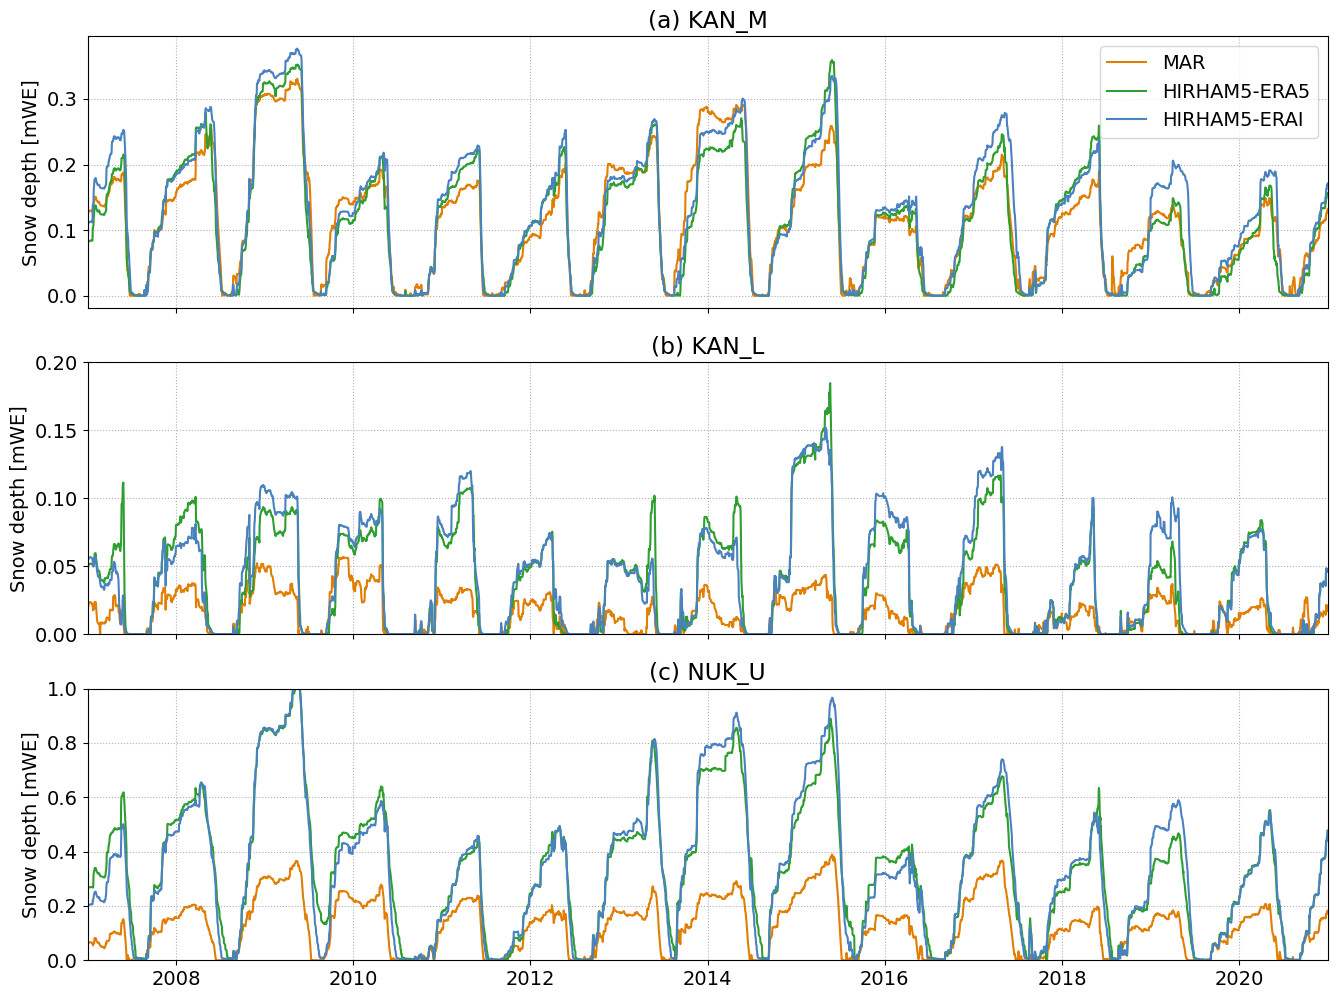

In [121]:
xst = 'KAN_M'
xst2 = 'KAN_L'
xst3 = 'NUK_U'


fig,ax = plt.subplots(3,1,figsize = (16,12), sharex=True)
ax[0].plot(AWS_RCM_sh[xst]*0.3, label = 'MAR', color = color_mar)
ax[0].plot(AWS_RCM_sh_HIRHAM5[xst], c = color_hirham5, label = 'HIRHAM5-ERA5')
ax[0].plot(AWS_RCM_sh_HIRHAMI[xst], c = color_hirhami, label = 'HIRHAM5-ERAI')
ax[0].legend()
ax[0].grid(linestyle = ':')
#ax[0].set_ylim(0,0.4)
ax[0].set_xlim(np.datetime64('2011-01-01'), np.datetime64('2020-12-31'))
ax[0].set_ylabel('Snow depth [mWE]')
ax[0].set_title(f"({chr(97)}) {xst}")  # Add (a) to the title

ax[1].plot(AWS_RCM_sh[xst2]*0.3, label = 'MAR',color = color_mar)
ax[1].plot(AWS_RCM_sh_HIRHAM5[xst2], c = color_hirham5, label = 'HIRHAM5-ERA5')
ax[1].plot(AWS_RCM_sh_HIRHAMI[xst2], c = color_hirhami, label = 'HIRHAM5-ERAI')

ax[1].grid(linestyle = ':')
ax[1].set_ylim(0,0.2)
ax[1].set_xlim(np.datetime64('2011-01-01'), np.datetime64('2020-12-31'))
ax[1].set_ylabel('Snow depth [mWE]')
ax[1].set_title(f"({chr(98)}) {xst2}")  # Add (b) to the title

ax[2].plot(AWS_RCM_sh[xst3]*0.3, label = 'MAR', color = color_mar)
ax[2].plot(AWS_RCM_sh_HIRHAM5[xst3], c = color_hirham5, label = 'HIRHAM5-ERA5')
ax[2].plot(AWS_RCM_sh_HIRHAMI[xst3], c = color_hirhami, label = 'HIRHAM5-ERAI')

ax[2].grid(linestyle = ':')
ax[2].set_ylim(0,1)
ax[2].set_xlim(np.datetime64('2007-01-01'), np.datetime64('2020-12-31'))
ax[2].set_ylabel('Snow depth [mWE]')
ax[2].set_title(f"({chr(99)}) {xst3}")  # Add (c) to the title
# make text on figure bigger
plt.rcParams.update({'font.size': 14})


In [144]:
# Filter the dataframe to include only summer months (June, July, August)
summer_months = [7, 8]
# remove some columns in the dataframe:
#remove_st = ['JAR', 'JAR_O', 'SWC_O','CEN2']
#AWS_RCM_sh = AWS_RCM_sh.drop(remove_st, axis = 1)
AWS_RCM_sh_summer = AWS_RCM_sh_lrc[AWS_RCM_sh_lrc.index.month.isin(summer_months)]
np.mean(AWS_RCM_sh_summer) - 273.15
#AWS_RCM_sh_summer.NUK_U.mean() - 273.15

#-4.048101806640602n AWS_RCM_sh_lrc MAR = -2.6175709089989154

-1.8674012742062018

In [57]:
# varlist = ['ahfl','ahfs','dlwrad','dswrad','evspsbl','rainfall','snfall','tas','grndhflx','tsl2','gld','rogl',
#            'tradsm','sradsm','albedom','supimp','tsl','rfrz']
# HIRHAM5 =  xr.open_mfdataset(home_dir2 + f'/HIRHAM5-ERA5_v2/Daily2D_{2020}*.nc', 
#                                 parallel=True, drop_variables = varlist,
#                                 concat_dim='time', combine='nested')

MAR = xr.open_dataset(home_dir + f'/marv3.12/MARv3.12.1-10km-daily-ERA5-{2020}.nc')
# import racmo 2020: 
RACMO = xr.open_dataset(home_dir + f'/RACMO2.3/Icemask_Topo_Iceclasses_lon_lat_average_1km_GrIS.nc')



<xarray.Dataset>
Dimensions:      (y: 2700, x: 1496)
Coordinates:
  * x            (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y            (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Data variables:
    Promicemask  (y, x) float32 ...
    Topography   (y, x) float32 ...
    LON          (y, x) float32 ...
    LAT          (y, x) float32 ...
Attributes:
    history:                    Wed Jul  3 11:54:15 2019: ncks -A -v LAT /Vol...
    history_of_appended_files:  Wed Jul  3 11:54:15 2019: Appended file /Volu...
    NCO:                        4.6.6

In [105]:
#MAR.coords['x'] = MAR.coords['x']*1000
#MAR.coords['y'] = MAR.coords['y']*1000
                # Rename TIME to time:
#MAR = MAR.rename_vars({'TIME': 'time'})
MAR_xy = RACMO.sel(x = np.array(clipped_aws_loc.geometry.x), y = np.array(clipped_aws_loc.geometry.y), method = 'nearest')

# transformer = pyproj.Transformer.from_crs('EPSG:4326','EPSG:3413')  
# lon = np.array(HIRHAM5.lon.data).flatten()
# lat = np.array(HIRHAM5.lat.data).flatten()

# lon, lat = transformer.transform(lat, lon)

# lat_lon_grid = np.column_stack((lon, lat))

#         # Build a KD-tree for efficient nearest neighbor searches
# tree = cKDTree(lat_lon_grid)      
# # Extract AWS coordinates and find their nearest neighbors in the grid
# aws_coords = np.column_stack([clipped_aws_loc.geometry.x, clipped_aws_loc.geometry.y])
# dist , closest_indices = tree.query(aws_coords, k=1)

# Make a empty pandas dataframe to store the data in:
lapse_corr = np.zeros(len(clipped_aws_loc))

for i in range(len(clipped_aws_loc)):
        # Set up data for dataframe:
        SH = np.array(MAR_xy.isel(x=i, y=i).Topography).squeeze()
        diff_alt = clipped_aws_loc.alt[i] - SH

        lapse_corr[i] = diff_alt * (-0.005)
        
#make a dataframe with the lapse correction:
lapse_corr_df = pd.DataFrame(data=lapse_corr, 
                                  index=clipped_aws_loc.index,
                                  columns=['lapse_corr'])
lapse_corr_df

,lapse_corr
stid,
QAS_L,0.2970
QAS_M,-0.0700
QAS_U,-0.0950
QAS_Uv3,-0.1030
QAS_A,0.0600
SDM,-0.0975
NUK_U,-0.2000
SDL,-0.0190
DY2,-0.0840


In [136]:
AWS_RCM_sh_lrc = AWS_RCM_sh_RACMO  + lapse_corr_df.lapse_corr

Text(0.5, 1.0, 'KAN_U Automatic Weather Station')

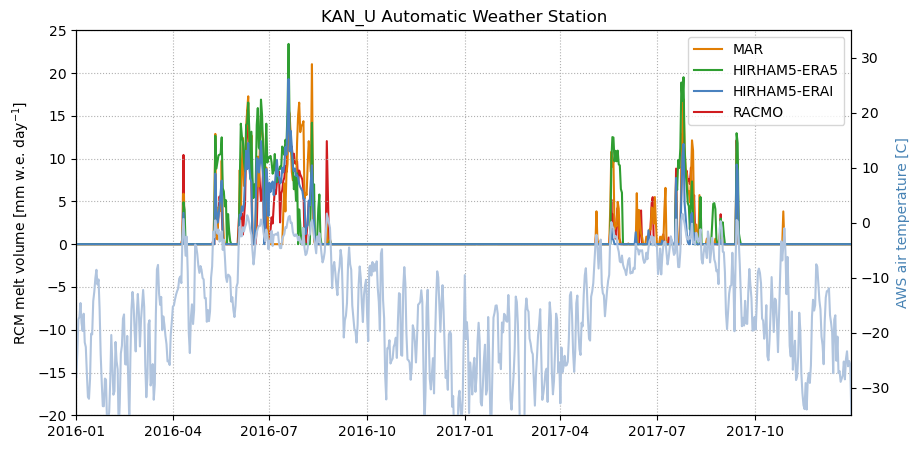

In [55]:
# Open data from KAN_U:
KAN_U = pd.read_csv(home_dir + '/AWS/combined/day/KAN_U_day.csv')
KAN_U['time'] = pd.to_datetime(KAN_U['time'])
# Select only the period from 2016-2018:
KAN_U = KAN_U.loc[(KAN_U['time'] >= '2016-01-01') & (KAN_U['time'] <= '2018-12-31')]
# select only t_u:
KAN_U = KAN_U[['time', 't_u']]
# plot the data:
fig,ax = plt.subplots(1,1,figsize = (10,5))
ax2 = ax.twinx()
ax2.plot(KAN_U.time, KAN_U.t_u, color = 'lightsteelblue', label = 'Air temperature', zorder = 1)
ax.plot(AWS_RCM_sh['KAN_U'], label = 'MAR', color = color_mar)
ax.plot(AWS_RCM_sh_HIRHAM5['KAN_U'], c = color_hirham5, label = 'HIRHAM5-ERA5', zorder = 10)
ax.plot(AWS_RCM_sh_HIRHAMI['KAN_U'], c = color_hirhami, label = 'HIRHAM5-ERAI', zorder = 10)
ax.plot(AWS_RCM_sh_RACMO['KAN_U'], c = color_racmo, label = 'RACMO', zorder = 1)
# make two y-axis:

ax.legend()
ax.grid(linestyle = ':')
#ax[0].set_ylim(0,0.4)
ax.set_xlim(np.datetime64('2016-01-01'), np.datetime64('2017-12-31'))
ax2.set_ylabel('AWS air temperature [C]', color = 'steelblue')
# set ylim: 
ax.set_ylim(-20,25)
ax2.set_ylim(-35,35)
ax.set_ylabel(r'RCM melt volume [mm w.e. day$^{-1}$]')
ax.set_title(f"{xst} Automatic Weather Station")  # Add (a) to the title



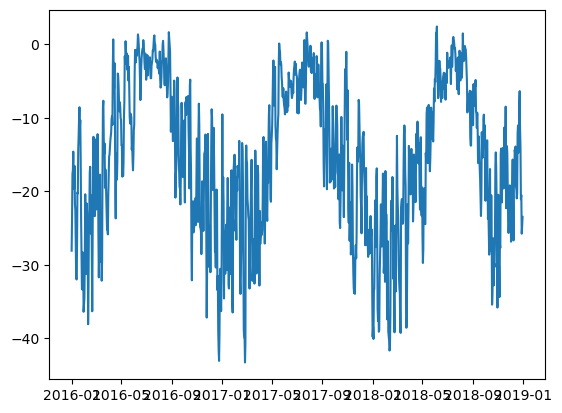

In [28]:
# Open data from KAN_U:
KAN_U = pd.read_csv(home_dir + '/AWS/combined/day/KAN_U_day.csv')
KAN_U['time'] = pd.to_datetime(KAN_U['time'])
# Select only the period from 2016-2018:
KAN_U = KAN_U.loc[(KAN_U['time'] >= '2016-01-01') & (KAN_U['time'] <= '2018-12-31')]
# select only t_u:
KAN_U = KAN_U[['time', 't_u']]
# plot
plt.plot(KAN_U.time, KAN_U.t_u)

array([2496.0683327 , 2799.51340195, 1741.25251928, 1746.201592  ,
       3059.26295843,  828.32485303, 2829.00834531, 1703.49526497,
       1009.70986058, 1421.82106974, 1307.35014761, 2645.60450424,
        910.97770065, 3235.55632811, 2840.82245536, 2757.55734385,
       2666.86409192, 2207.48983272, 2321.53862238, 1861.04485697,
        535.82173258, 1597.82776302, 1950.89645743, 3291.62403292,
       2476.29384853, 2615.18121796, 1533.74483524,  514.46912361,
       2238.11883616, 1530.91078373, 3160.64002521, 3168.95938098,
       2635.15168685, 2672.09080425, 2603.57372031, 1366.9917558 ,
       3332.44708556, 2801.51213098])

array([469777.3813997 ,  -9213.22776786])

In [91]:
RCM = xr.open_dataset(home_dir + f'/RACMO2.3/t2m/t2m.{2008}_JAS.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc')
                # remane t2m to TT: 
RCM = RCM.rename_vars({'t2m': 'TT'})
                # Sample in points:
# Convert km to m:
RCM.coords['x'] = RCM.coords['x']*1000
RCM.coords['y'] = RCM.coords['y']*1000

sampled_df = sample_xarray_points(RCM, clipped_aws_loc)

<Axes: >

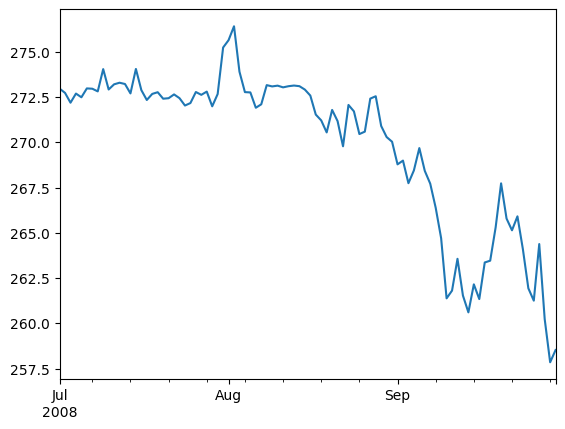

In [93]:
sampled_df.SDL.plot()


<Axes: >

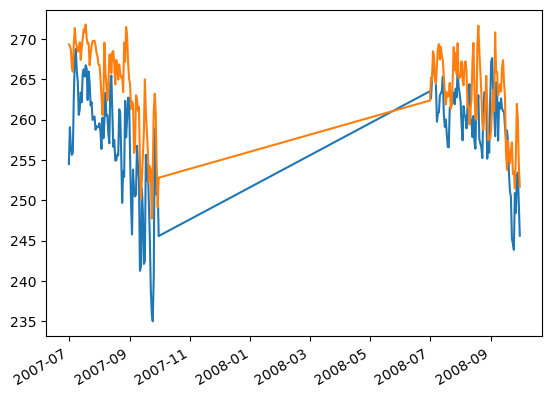

In [133]:
AWS_RCM_sh_RACMO_2 = AWS_RCM_sh_lrc 
AWS_RCM_sh_RACMO.Summit.plot()
AWS_RCM_sh_RACMO.SDL.plot()

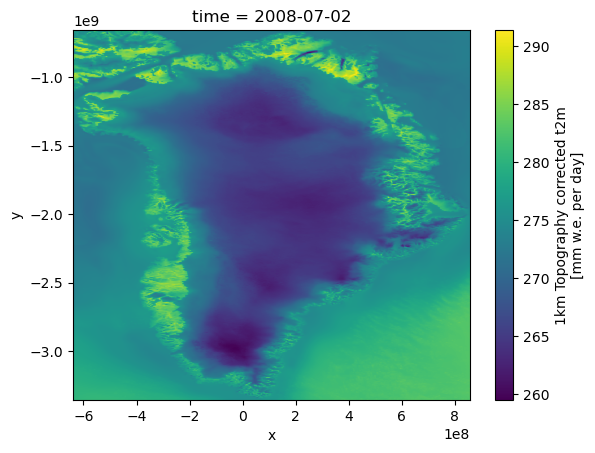

In [125]:
RCM.TT.isel(time=1).plot()

In [130]:
AWS_RCM_sh_RACMO

,QAS_L,QAS_M,QAS_U,QAS_Uv3,QAS_A,SDM,NUK_U,SDL,DY2,NSE,...,UPE_L,GITS,CEN1,CEN2,HUM,PetermannELA,EGP,TUN,KPC_U,KPC_L
2007-07-01,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,...,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674,273.246674
2007-07-02,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,...,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023,273.305023
2007-07-03,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,...,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256,273.243256
2007-07-04,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,...,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988,273.118988
2007-07-05,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,...,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300,273.038300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-26,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,...,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874,261.257874
2008-09-27,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,...,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331,264.383331
2008-09-28,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,...,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983,260.238983
2008-09-29,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,...,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621,257.855621
